In [156]:
import os
import getpass
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage, ToolMessage
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableParallel, RunnableLambda, RunnableBranch
from langchain_core.tools import tool, StructuredTool
import yfinance as yf
import requests
from typing import Dict, Any, List, Optional
from langsmith import traceable
from tavily import TavilyClient
from langchain_core.runnables import RunnableConfig
from dataclasses import dataclass, fields, field
import json
from typing_extensions import TypedDict, Annotated, Literal
import operator
from IPython.display import Markdown
from bs4 import BeautifulSoup
from urllib.request import urlopen
from enum import Enum

In [157]:
load_dotenv()

True

In [158]:
llm = ChatGroq(model_name = 'Gemma2-9b-it', api_key = os.getenv('GROQ_API_KEY'))

## Prompt

In [159]:
query_writer_instruction_web = """Your goal is to generate a targeted web search query related to financial investments or any finance-related topic specified by the user.

<TOPIC>
{finance_topic}
</TOPIC>

<FORMAT>
Format your response as a JSON object with ALL three of these exact keys:
   - "query": The actual search query string
   - "aspect": The specific aspect of the finance topic being researched
   - "rationale": Brief explanation of why this query is relevant
</FORMAT>

<EXAMPLE>
Example output:
{{
    "query": "best index funds for long-term investment 2025",
    "aspect": "investment strategy",
    "rationale": "Identifying top-performing index funds for long-term portfolio growth"
}}
</EXAMPLE>

Provide your response in JSON format:
"""

summarizer_instruction_web = """<GOAL>
Generate a high-quality summary of the web search results, focusing on financial investments or the specific finance-related topic requested by the user.
</GOAL>

<REQUIREMENTS>
When creating a NEW summary:
1. Highlight the most relevant financial insights, trends, or strategies from the search results.
2. Ensure a coherent flow of information while keeping it concise and actionable.

When EXTENDING an existing summary:
1. Read the existing summary and new search results carefully.
2. Compare the new information with the existing summary.
3. For each piece of new information:
    a. If it builds on an existing point, integrate it smoothly.
    b. If it introduces a new relevant aspect, add a separate paragraph.
    c. If it’s irrelevant to financial investments, ignore it.
4. Ensure all additions align with the user’s finance-related query.
5. Verify that the final output differs from the original summary while improving its depth.

<FORMATTING>
- Start directly with the updated summary, without preamble or titles. Do not use XML tags in the output.
</FORMATTING>
"""

reflection_instructions_web = """You are an expert financial research assistant analyzing a summary about {finance_topic}.

<GOAL>
1. Identify missing details or areas that need deeper exploration.
2. Generate a follow-up question to help expand financial knowledge.
3. Focus on investment strategies, market trends, risk factors, regulations, or financial instruments that weren’t fully covered.
</GOAL>

<REQUIREMENTS>
Ensure the follow-up question is self-contained and provides necessary context for a web search.
</REQUIREMENTS>

<FORMAT>
Format your response as a JSON object with these exact keys:
- "knowledge_gap": Describe what financial information is missing or unclear.
- "follow_up_query": Write a specific question to address this gap.
</FORMAT>

<EXAMPLE>
Example output:
{{
    "knowledge_gap": "The summary does not mention tax implications of investing in ETFs vs. mutual funds.",
    "follow_up_query": "What are the tax advantages and disadvantages of ETFs compared to mutual funds?"
}}
</EXAMPLE>

Provide your analysis in JSON format:
"""


## States

In [160]:
class State(TypedDict):
    route: Literal['Web_query', 'Normal_query', 'Financial_Analysis'] = Field(None)
    research_topic: str = ""
    search_query: str = ""
    web_research_results: Annotated[list, operator.add] = []
    sources_gathered: Annotated[list, operator.add] = []
    research_loop_count: int = 0
    running_summary: str = ""
    messages: Annotated[list, operator.add] = []

In [161]:
def create_initial_state(user_query: str):
    return {
        "route": None,
        "research_topic": user_query,
        "search_query": "",
        "web_research_results": [],
        "sources_gathered": [],
        "research_loop_count": 0,
        "running_summary": "",
        "messages": [HumanMessage(content=user_query)]
    }

## First Routing Step

In [162]:
class Route_First_Step(BaseModel):
    step: Literal['Web_query', 'Normal_query', 'Financial_Analysis'] = Field(None, description = 'Given the query, determine whether to perform a web search, answer a normal question(like a definition), or perform a financial analysis(for which you have tools).')

In [163]:
class SearchAPI(Enum):
    PERPLEXITY = "perplexity"
    TAVILY = "tavily"
    DUCKDUCKGO = "duckduckgo"

@dataclass(kw_only=True)
class Configuration:
    """The configurable fields for the research assistant."""
    max_web_research_loops: int = int(os.environ.get("MAX_WEB_RESEARCH_LOOPS", "3"))
    #local_llm: str = llm
    search_api: SearchAPI = SearchAPI(os.environ.get("SEARCH_API", SearchAPI.TAVILY.value))  # Default to DUCKDUCKGO
    fetch_full_page: bool = os.environ.get("FETCH_FULL_PAGE", "False").lower() in ("true", "1", "t")
    ollama_base_url: str = os.environ.get("OLLAMA_BASE_URL", "http://localhost:11434/")

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})

In [164]:
@traceable
def tavily_search(query, include_raw_content=True, max_results=3):
    """ Search the web using the Tavily API.

    Args:
        query (str): The search query to execute
        include_raw_content (bool): Whether to include the raw_content from Tavily in the formatted string
        max_results (int): Maximum number of results to return

    Returns:
        dict: Search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str): Full content of the page if available"""

    api_key = os.environ['TAVILY_API_KEY']
    if not api_key:
        raise ValueError("TAVILY_API_KEY environment variable is not set")
    tavily_client = TavilyClient(api_key=api_key)
    return tavily_client.search(query,
                         max_results=max_results,
                         include_raw_content=include_raw_content)

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=False):
    """
    Takes either a single search response or list of responses from search APIs and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.

    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results

    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")

    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source

    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"

    return formatted_text.strip()

def format_sources(search_results):
    """Format search results into a bullet-point list of sources.

    Args:
        search_results (dict): Tavily search response containing results

    Returns:
        str: Formatted string with sources and their URLs
    """
    return '\n'.join(
        f"* {source['title']} : {source['url']}"
        for source in search_results['results']
    )

def generate_query(state: State, config: RunnableConfig):
    """Generate a query for web search."""
    # Format the prompt using the correct placeholder
    query_writer_instruction_web_formatted = query_writer_instruction_web.format(finance_topic=state["research_topic"])
    prompt = query_writer_instruction_web_formatted + "\nGenerate a query for web search:"

    result = llm.invoke(prompt)
    output_text = result.content.strip()
# In generate_query function:
    try:
        query_data = json.loads(output_text)
        return {"search_query": query_data['query']}
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error parsing JSON: {e}")
        return {"search_query": f"comprehensive analysis of {state['research_topic']}"}

def web_research(state: State, config: RunnableConfig):
    """Gather information from the web."""
    configurable = Configuration.from_runnable_config(config)

    # Determine which search API to use
    if isinstance(configurable.search_api, str):
        search_api = configurable.search_api
    else:
        search_api = configurable.search_api.value

    if search_api == "tavily":
        search_results = tavily_search(state["search_query"], include_raw_content=True, max_results=1)
        search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=True)
    else:
        raise ValueError(f"Unsupported search API: {configurable.search_api}")

    return {
        "sources_gathered": [format_sources(search_results)],
        "research_loop_count": state["research_loop_count"] + 1,
        "web_research_results": [search_str]
    }


def summarize_sources(state: State, config: RunnableConfig):
    """Summarize the gathered sources."""
    # Existing summary and most recent search results
    existing_summary = state['running_summary']
    most_recent_web_research = state['web_research_results'][-1]

    if existing_summary:
        human_message_content = (
            f"<User Input> \n {state['research_topic']} \n <User Input>\n\n"
            f"<Existing Summary> \n {existing_summary} \n <Existing Summary>\n\n"
            f"<New Search Results> \n {most_recent_web_research} \n <New Search Results>"
        )
    else:
        human_message_content = (
            f"<User Input> \n {state['research_topic']} \n <User Input>\n\n"
            f"<Search Results> \n {most_recent_web_research} \n <Search Results>"
        )

    prompt = summarizer_instruction_web + "\n" + human_message_content

    result = llm.invoke(prompt)
    running_summary = result.content

    # Remove any unwanted <think> tags
    while "<think>" in running_summary and "</think>" in running_summary:
        start = running_summary.find("<think>")
        end = running_summary.find("</think>") + len("</think>")
        running_summary = running_summary[:start] + running_summary[end:]

    return {"running_summary": running_summary}

def reflect_on_summary(state: State, config: RunnableConfig):
    """Reflect on the summary and generate a follow-up query."""
    prompt = (
        reflection_instructions_web.format(finance_topic=state['research_topic'])
        + "\nIdentify a knowledge gap and generate a follow-up web search query based on our existing knowledge: "
        + state['running_summary']
    )

    result = llm.invoke(prompt)
    
    output_text = result.content.strip()
    try:
        follow_up_query = json.loads(output_text)
    except json.JSONDecodeError:
        print("Error: Could not decode JSON from reflect_on_summary. Response was:", output_text)
        # Fallback: Return a default follow-up query
        follow_up_query = {"follow_up_query": f"Tell me more about {state['research_topic']}"}

    query = follow_up_query.get('follow_up_query')
    if not query:
        return {"search_query": f"Tell me more about {state['research_topic']}"}
    return {"search_query": query}


def finalize_summary(state: State):
    """Finalize the summary by aggregating all source information."""
    all_sources = "\n".join(source for source in state['sources_gathered'])
    final_summary = f"## Summary\n\n{state['running_summary']}\n\n### Sources:\n{all_sources}"
    
    # Create a consistent message output
    final_message = HumanMessage(content=final_summary)
    
    return {
        "running_summary": final_summary,
        "messages": [final_message]  # Add this to ensure consistency with other branches
    }

def route_research(state: State, config: RunnableConfig) -> Literal["finalize_summary", "web_research"]:
    configurable = Configuration.from_runnable_config(config)
    if state['research_loop_count'] < configurable.max_web_research_loops:  # Changed to <
        return "web_research"
    return "finalize_summary"

In [165]:
router = llm.with_structured_output(Route_First_Step)

In [166]:
def call_route_first_step(state: State):
    
    # Make the routing decision
    decision = router.invoke(state["research_topic"])
    
    # Update the state with the route and research_topic
    return {
        "route": decision.step,
    }

In [167]:
def validate_state_transition(old_state: State, new_state: State):
    required_fields = set(State.__annotations__.keys())
    missing = required_fields - set(new_state.keys())
    if missing:
        raise ValueError(f"Missing state updates for: {missing}")
    return True

In [188]:
from langchain_core.tools import tool, StructuredTool
import yfinance as yf



@tool
def company_address(ticker: str) -> str:
    """
    Returns company address for input ticker.
    e.g. company_address: AAPL
    Returns company address for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return " ".join([info[key] for key in ['address1','city','state','zip','country']])

@tool
def fulltime_employees(ticker: str) -> int:
    """
    Returns fulltime employees count for input ticker.
    e.g. company_address: MSFT
    Returns fulltime employees count for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['fullTimeEmployees']

@tool
def last_close_price(ticker: str) -> float:
    """
    Returns last close price for input ticker.
    e.g. company_address: MSFT
    Returns last close price for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['previousClose']

@tool
def EBITDA(ticker: str) -> float:
    """
    Returns EBITDA for input ticker.
    e.g. company_address: AAPL
    Returns EBITDA for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['ebitda']

@tool
def total_debt(ticker: str) -> float:
    """
    Returns total debt for input ticker.
    e.g. company_address: AAPL
    Returns total debt for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['totalDebt']

@tool
def total_revenue(ticker: str) -> float:
    """
    Returns total revenue for input ticker.
    e.g. company_address: MSFT
    Returns total revenue for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['totalRevenue']

@tool
def debt_to_equity_ratio(ticker: str) -> float:
    """
    Returns debt to equity ratio for input ticker.
    e.g. company_address: AAPL
    Returns debt to equity ratio for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['debtToEquity']

finance_tools = [
    company_address,
    fulltime_employees,
    last_close_price,
    EBITDA,
    total_debt,
    total_revenue,
    debt_to_equity_ratio
]

finance_tool_map = {t.name: t for t in finance_tools}

In [189]:
llm_normal = llm
normal_query_prompt = """
You are a financial analyst. Please answer the user's question based on what you know, don't make up anything.
"""


In [190]:
def answer_normal_query(state: State):
    # Get the messages from the state
    messages = state.get('messages', [])
    # Add system message
    system_message = SystemMessage(content=normal_query_prompt)
    # Invoke LLM with both system and user messages
    message = llm_normal.invoke([system_message] + messages)
    # Return in the correct format - use 'messages' to match other branches
    return {"messages": [message]} 

In [191]:
llm_financial_analysis = llm.bind_tools(finance_tools, tool_choice = 'auto')
financial_analysis_prompt = """
You are a financial analyst. You are given tools for acurate data
"""


In [192]:
def call_llm(state: State):
    messages = state['messages']
    if financial_analysis_prompt:
        messages = [SystemMessage(content=financial_analysis_prompt)] + messages
    message = llm_financial_analysis.invoke(messages)
    return {'messages': [message]}

def exists_action(state: State):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

def take_action(state: State):
    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        try:
            tool_func = finance_tool_map[t['name']]
            result = tool_func.invoke(t['args'])
        except KeyError:
            result = f"Error: Tool {t['name']} not found"
        except Exception as e:
            result = f"Error executing tool: {str(e)}"
        results.append(ToolMessage(
            tool_call_id=t['id'],
            name=t['name'],
            content=str(result)
        ))
    return {'messages': results}

## Final Route Builder

In [193]:
def get_route(state: State) -> str:
    return state["route"]


In [194]:
final_router = StateGraph(State)
final_router.add_node("route_first_step", call_route_first_step)

final_router.add_node("generate_query", generate_query)
final_router.add_node("web_research", web_research)
final_router.add_node("summarize_sources", summarize_sources)
final_router.add_node("reflect_on_summary", reflect_on_summary)
final_router.add_node("finalize_summary", finalize_summary)
final_router.add_node('call_llm', call_llm)
final_router.add_node('take_action', take_action)
final_router.add_node('answer_normal_query', answer_normal_query)
final_router.add_edge(START, "route_first_step")
final_router.add_conditional_edges("route_first_step", get_route, {
    'Web_query': 'generate_query',
    'Normal_query': 'answer_normal_query',
    'Financial_Analysis': 'call_llm'
})

final_router.add_edge("answer_normal_query", END)
final_router.add_conditional_edges(
            "call_llm",
            exists_action,
            {True: "take_action", False: END}
        )
final_router.add_edge("take_action", "call_llm")

final_router.add_edge("generate_query", "web_research")
final_router.add_edge("web_research", "summarize_sources")
final_router.add_edge("summarize_sources", "reflect_on_summary")
final_router.add_conditional_edges("reflect_on_summary", route_research)
final_router.add_edge("finalize_summary", END)

In [195]:
final_model = final_router.compile()

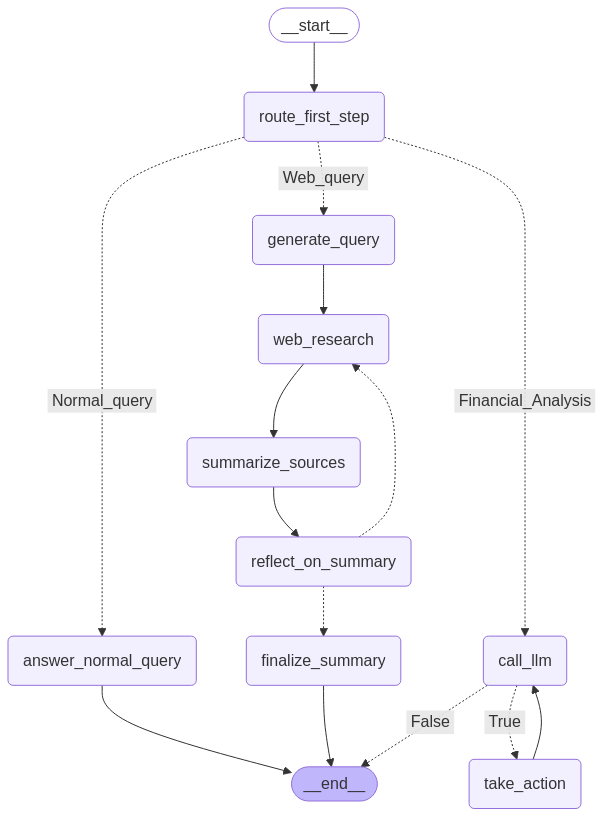

In [196]:
display(Image(final_model.get_graph().draw_mermaid_png()))

In [197]:
initial_state = {
    "query": "What does stock mean?",
    "route": None,
    "research_topic": "What does stock mean?",
    "search_query": "What does stock mean?",
    "web_research_results": [],
    "sources_gathered": [],
    "research_loop_count": 0,
    "running_summary": "",
    "message": []
}
normal_query = final_model.invoke(initial_state)


In [198]:
if __name__ == "__main__":
    # Initialize with proper state structure
    initial_state = create_initial_state("What is EBIDTA of Apple Inc?")
    
    # Execute workflow
    result = final_model.invoke(initial_state)
    
    # Validate final state
    validate_state_transition(initial_state, result)
    print("Final state validated successfully!")
    print("Summary:", result["running_summary"])

Final state validated successfully!
Summary: 


In [199]:
result

{'route': 'Financial_Analysis',
 'research_topic': 'What is EBIDTA of Apple Inc?',
 'search_query': '',
 'web_research_results': [],
 'sources_gathered': [],
 'research_loop_count': 0,
 'running_summary': '',
 'messages': [HumanMessage(content='What is EBIDTA of Apple Inc?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xw2g', 'function': {'arguments': '{"ticker":"AAPL"}', 'name': 'EBITDA'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 1786, 'total_tokens': 1868, 'completion_time': 0.149090909, 'prompt_time': 0.061491905, 'queue_time': 0.23879569899999997, 'total_time': 0.210582814}, 'model_name': 'Gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ecfe8120-b3ba-4ac7-b87f-9c164d74832a-0', tool_calls=[{'name': 'EBITDA', 'args': {'ticker': 'AAPL'}, 'id': 'call_xw2g', 'type': 'tool_call'}], usage_metadata=

In [200]:
result['messages'][-1].content

'The EBITDA of Apple Inc is 137352003584.'

In [186]:
Markdown(result['messages'][-1].content)

## Summary

Reliance Industries' stock is experiencing positive momentum, reversing its recent decline. Leading brokerages like Macquarie, Morgan Stanley, and Kotak Institutional Equities have upgraded their ratings and target prices for the company, citing strong earnings momentum and anticipation for a potential listing of Jio, Reliance's telecom subsidiary. Macquarie notes that Reliance has underperformed the MSCI India index and Bharti Airtel in the past year, presenting a growth opportunity. Morgan Stanley maintains an "Overweight" rating with a target price of Rs 1,606, while Kotak Institutional Equities upgraded its rating to "Buy" with a target price of Rs 1,400.  Adding to this positive outlook, Motilal Oswal Financial Services has also recommended buying Reliance Industries shares with a target price of Rs 1,605. This surge in investor confidence is reflected in the company's recent market performance, with a significant increase in market capitalization among the top-10 most valued firms in India. 

Reliance Retail has re-launched Shein in India, potentially sparking a fast fashion war and challenging competitors like Trent's Zudio and Nykaa Fashion. Despite this potential competition, experts suggest that Shein's online-first model might face challenges in supply chain establishment and unit economics.  

The combined market valuation of six of the top-10 most valued firms, including Reliance Industries, surged Rs 1,18,151.75 crore last week.  HDFC Bank and Bharti Airtel emerged as the biggest gainers during this period,  in-line with firm trend in equities.   





### Sources:
* Reliance Industries Gain Momentum As Brokerages Project Positive ... : https://www.timesnownews.com/business-economy/companies/reliance-industries-gain-momentum-as-brokerages-project-positive-perfomance-with-upgraded-target-price-article-118838825
* Reliance Industries News - Reliance Industries Announcement, Latest ... : https://economictimes.indiatimes.com/reliance-industries-ltd/stocksupdate/companyid-13215.cms
* Reliance Industries News - Reliance Industries Announcement, Latest ... : https://economictimes.indiatimes.com/reliance-industries-ltd/stocksupdate/companyid-13215.cms